In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pl.Config.set_tbl_width_chars(200)

polars.config.Config

In [3]:
path  = './yt_dataset/GBvideos.csv'

### Data

In [4]:
%%time
df_pl = pl.read_csv(path)

CPU times: user 141 ms, sys: 101 ms, total: 242 ms
Wall time: 140 ms


### Common Exploratory Methods

In [5]:
print(df_pl.shape)
print(df_pl.head(2))
#print(df_pl.tail(2))
#print(df_pl.sample(2))

(38916, 16)
shape: (2, 16)
┌─────────────┬───────────────┬─────────────────────────────────┬─────────────────────┬───┬───────────────────┬──────────────────┬────────────────────────┬─────────────────────────────────┐
│ video_id    ┆ trending_date ┆ title                           ┆ channel_title       ┆ … ┆ comments_disabled ┆ ratings_disabled ┆ video_error_or_removed ┆ description                     │
│ ---         ┆ ---           ┆ ---                             ┆ ---                 ┆   ┆ ---               ┆ ---              ┆ ---                    ┆ ---                             │
│ str         ┆ str           ┆ str                             ┆ str                 ┆   ┆ bool              ┆ bool             ┆ bool                   ┆ str                             │
╞═════════════╪═══════════════╪═════════════════════════════════╪═════════════════════╪═══╪═══════════════════╪══════════════════╪════════════════════════╪═════════════════════════════════╡
│ Jw1Y-zhQURU ┆ 17.14.1

In [6]:
import polars.selectors as cs

# Polars feature selectiom
numeric_data_pl = df_pl.select(cs.numeric())
categorical_data_pl = df_pl.select(cs.string())
print(numeric_data_pl.head())

shape: (5, 5)
┌─────────────┬──────────┬────────┬──────────┬───────────────┐
│ category_id ┆ views    ┆ likes  ┆ dislikes ┆ comment_count │
│ ---         ┆ ---      ┆ ---    ┆ ---      ┆ ---           │
│ i64         ┆ i64      ┆ i64    ┆ i64      ┆ i64           │
╞═════════════╪══════════╪════════╪══════════╪═══════════════╡
│ 26          ┆ 7224515  ┆ 55681  ┆ 10247    ┆ 9479          │
│ 24          ┆ 1053632  ┆ 25561  ┆ 2294     ┆ 2757          │
│ 10          ┆ 17158579 ┆ 787420 ┆ 43420    ┆ 125882        │
│ 17          ┆ 27833    ┆ 193    ┆ 12       ┆ 37            │
│ 25          ┆ 9815     ┆ 30     ┆ 2        ┆ 30            │
└─────────────┴──────────┴────────┴──────────┴───────────────┘


In [7]:
susbet_pl = df_pl[["likes", "views", "comment_count"]]
print(susbet_pl.head())

shape: (5, 3)
┌────────┬──────────┬───────────────┐
│ likes  ┆ views    ┆ comment_count │
│ ---    ┆ ---      ┆ ---           │
│ i64    ┆ i64      ┆ i64           │
╞════════╪══════════╪═══════════════╡
│ 55681  ┆ 7224515  ┆ 9479          │
│ 25561  ┆ 1053632  ┆ 2757          │
│ 787420 ┆ 17158579 ┆ 125882        │
│ 193    ┆ 27833    ┆ 37            │
│ 30     ┆ 9815     ┆ 30            │
└────────┴──────────┴───────────────┘


In [8]:
# how many rows in the dataset have less than 1000 views
filtered_pl = df_pl.filter(pl.col("views") < 1000)
filtered_pl.shape

(6, 16)

### Data Quality Checks

In [28]:
# check for the number of missing rows per column and the number of static columns
missing = (
    df_pl.select(pl.all().is_null().sum())
    .unpivot(value_name="missing")
    .filter(pl.col("missing") > 0)
)
static = (
    df_pl.select(pl.all().n_unique())
    .unpivot(value_name="unique")
    .filter(pl.col("unique") == 1)
)
print("Missing columns:")
print(missing)

print("nStatic columns:")
print(static)

Missing columns:
shape: (0, 2)
┌──────────┬─────────┐
│ variable ┆ missing │
│ ---      ┆ ---     │
│ str      ┆ u32     │
╞══════════╪═════════╡
└──────────┴─────────┘
nStatic columns:
shape: (0, 2)
┌──────────┬────────┐
│ variable ┆ unique │
│ ---      ┆ ---    │
│ str      ┆ u32    │
╞══════════╪════════╡
└──────────┴────────┘


### Data Pre-Processing
- Convert date columns into datetime format
- Replace category IDs with the actual category names


In [10]:
# Polars datetime conversion
df_pl = df_pl.with_columns(
    pl.col('trending_date').str.to_date(format='%y.%d.%m'),
    pl.col('publish_time').str.to_datetime()
)

In [11]:
### ikigai book

In [12]:
import json

with open('./yt_dataset/US_category_id.json', 'r') as f:
    categories = json.load(f)
    
id_to_category = {}
for c in categories['items']:
    id_to_category[int(c['id'])] = c['snippet']['title']

In [32]:
df_pl = df_pl.with_columns(
    pl.col("category_id").replace_strict(id_to_category, default="Unknown").alias("category")
)

### Basic Exploratory Data Analysis

This section will cover the some of the most important techniques when doing EDA, namely univariate data analysis, aggregates, and visualisations.

Univariate data analysis is the simplest analysis you can do yet it’s crucial. Looking at one variable at a time, it can give you a better sense of data and can guide your further explorations.

In [14]:
category_counts = df_pl['category'].value_counts(sort=True).head()
print(category_counts)

shape: (5, 2)
┌──────────────────┬───────┐
│ category         ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ Music            ┆ 13754 │
│ Entertainment    ┆ 9124  │
│ People & Blogs   ┆ 2926  │
│ Film & Animation ┆ 2577  │
│ Howto & Style    ┆ 1928  │
└──────────────────┴───────┘


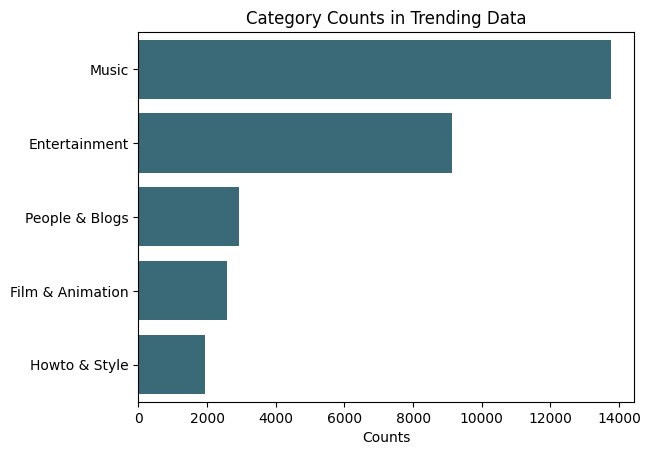

In [15]:
# Barplot
sns.barplot(
    y=category_counts["category"].to_numpy(),
    x=category_counts["count"].to_numpy(),
    color="#306e81",
)
plt.title("Category Counts in Trending Data")
plt.xlabel("Counts")
plt.show()

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ views        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 38916.0      │
│ null_count ┆ 0.0          │
│ mean       ┆ 5.9119e6     │
│ std        ┆ 1.9001e7     │
│ min        ┆ 851.0        │
│ 25%        ┆ 251532.0     │
│ 50%        ┆ 982006.0     │
│ 75%        ┆ 3.683523e6   │
│ max        ┆ 4.24538912e8 │
└────────────┴──────────────┘


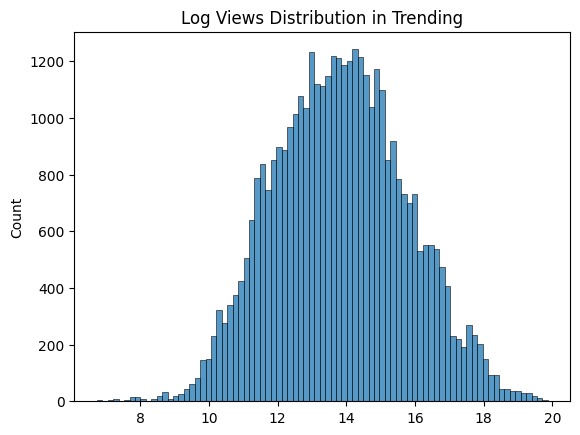

In [16]:
views_stats = df_pl.select(pl.col("views")).describe()
print(views_stats)

sns.histplot(df_pl['views'].log())
plt.title("Log Views Distribution in Trending")
plt.show()

### Multivariate Data Analysis

First things first, which channels appear most frequently in the trending page? We can again use .value_counts() but let’s use the .groupby().agg() method instead since it’s much more flexible and will be useful going forward. I’m going to group by the channel title and count the number of rows using .count() method

In [17]:
channel_popularity = (
    df_pl.group_by(pl.col("channel_title"))
    .agg(pl.len().alias("trending_count"))
    .sort(pl.col("trending_count"), descending=True)
)

print(channel_popularity.head())

shape: (5, 2)
┌─────────────────────────────────┬────────────────┐
│ channel_title                   ┆ trending_count │
│ ---                             ┆ ---            │
│ str                             ┆ u32            │
╞═════════════════════════════════╪════════════════╡
│ The Tonight Show Starring Jimm… ┆ 208            │
│ Jimmy Kimmel Live               ┆ 207            │
│ TheEllenShow                    ┆ 207            │
│ Saturday Night Live             ┆ 206            │
│ WWE                             ┆ 205            │
└─────────────────────────────────┴────────────────┘


Let’s create a few other statistics namely:

- Number of unique trendy videos
- Total number of views, likes and comments
- Average number of views likes and comments


In [18]:
channel_stats_pl = df_pl.group_by("channel_title").agg(
    pl.len().alias("trending_count"), # number of occurences in the dataset
    pl.col("title").n_unique().alias("number_of_trending_videos"), # number of unique trending videos
    pl.col("views").sum().alias("total_views"), # total number of views
    pl.col("likes").sum().alias("total_likes"), # total number of likes
    pl.col("comment_count").sum().alias("total_comments"), # total number of comments
    pl.col("views").mean().alias("average_views"), # average number of views
    pl.col("likes").mean().alias("average_likes"), # average number of likes
    pl.col("comment_count").mean().alias("average_comments"), # average number of comments
)
print(channel_stats_pl.sample(5))

shape: (5, 9)
┌─────────────────────────────────┬────────────────┬───────────────────────────┬─────────────┬───┬────────────────┬───────────────┬───────────────┬──────────────────┐
│ channel_title                   ┆ trending_count ┆ number_of_trending_videos ┆ total_views ┆ … ┆ total_comments ┆ average_views ┆ average_likes ┆ average_comments │
│ ---                             ┆ ---            ┆ ---                       ┆ ---         ┆   ┆ ---            ┆ ---           ┆ ---           ┆ ---              │
│ str                             ┆ u32            ┆ u32                       ┆ i64         ┆   ┆ i64            ┆ f64           ┆ f64           ┆ f64              │
╞═════════════════════════════════╪════════════════╪═══════════════════════════╪═════════════╪═══╪════════════════╪═══════════════╪═══════════════╪══════════════════╡
│ ElAnalistaDeBits                ┆ 11             ┆ 1                         ┆ 2052760     ┆ … ┆ 6866           ┆ 186614.545455 ┆ 1041.818182   ┆ 624

#### refactor the aggregation code into a function

In [22]:
def make_aggregates(df: pl.DataFrame, group_by: str, agg_features: list[str]) -> pl.DataFrame:
    # Aggregates that measure popularity using video counts
    popularity_aggs = [
        pl.len().alias("trending_count"),
        pl.col("title").n_unique().alias("number_of_trending_videos"),
    ]
    # Aggregates that measure popularity using metrics of the videos
    metrics_agg = []
    for agg in agg_features:
        if agg not in df.columns:
            print(f"{agg} not in the dataframe. Skipping...")
        else:
            metrics_agg.append(pl.col(agg).sum().alias(f"total_{agg}"))
            metrics_agg.append(pl.col(agg).mean().alias(f"average_{agg}"))

    stats = df.group_by(group_by).agg(popularity_aggs + metrics_agg)
    stats = stats.sort("trending_count", descending=True)
    return stats

In [23]:
channel_aggs = make_aggregates(
    df = df_pl, 
    group_by = "channel_title", 
    agg_features = ["views", "likes", "comment_count"]
)
category_aggs = make_aggregates(
    df = df_pl, 
    group_by = "category", 
    agg_features = ["views", "likes", "comment_count"]
)

print("Top Channels")
print(channel_aggs.head())

print("nTop Categories")
print(category_aggs.head())

Top Channels
shape: (5, 9)
┌─────────────────────────────────┬────────────────┬───────────────────────────┬─────────────┬───┬─────────────┬───────────────┬─────────────────────┬───────────────────────┐
│ channel_title                   ┆ trending_count ┆ number_of_trending_videos ┆ total_views ┆ … ┆ total_likes ┆ average_likes ┆ total_comment_count ┆ average_comment_count │
│ ---                             ┆ ---            ┆ ---                       ┆ ---         ┆   ┆ ---         ┆ ---           ┆ ---                 ┆ ---                   │
│ str                             ┆ u32            ┆ u32                       ┆ i64         ┆   ┆ i64         ┆ f64           ┆ i64                 ┆ f64                   │
╞═════════════════════════════════╪════════════════╪═══════════════════════════╪═════════════╪═══╪═════════════╪═══════════════╪═════════════════════╪═══════════════════════╡
│ The Tonight Show Starring Jimm… ┆ 208            ┆ 51                        ┆ 447390019   ┆ … ┆

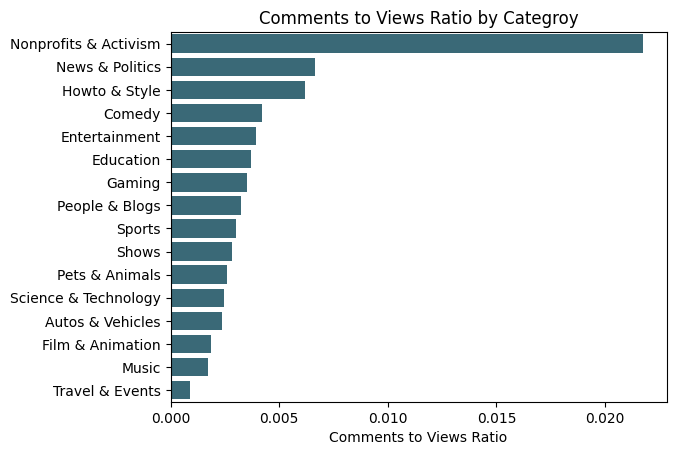

In [25]:
# Calcualte ratio
comments_views_ratio = category_aggs.select(
    pl.col("category"),
    comments_views_ratio=pl.col("total_comment_count") / pl.col("total_views")
).sort("comments_views_ratio", descending=True)

# Barplot
sns.barplot(
    y=comments_views_ratio["category"].to_numpy(),
    x=comments_views_ratio["comments_views_ratio"].to_numpy(),
    color="#306e81",
)
plt.title("Comments to Views Ratio by Categroy")
plt.xlabel("Comments to Views Ratio")
plt.show()

### Time Series Analysis

In [30]:
from typing import Dict
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [31]:
csv_path  = './yt_dataset/GBvideos.csv'
json_path = './yt_dataset/US_category_id.json'

df = pl.read_csv(csv_path)

with open(json_path, 'r') as f:
    categories = json.load(f)
    
id_to_category = {}
for c in categories['items']:
    id_to_category[int(c['id'])] = c['snippet']['title']

In [33]:
df[['publish_time','trending_date']].head()

publish_time,trending_date
str,str
"""2017-11-10T07:38:29.000Z""","""17.14.11"""
"""2017-11-12T06:24:44.000Z""","""17.14.11"""
"""2017-11-10T17:00:03.000Z""","""17.14.11"""
"""2017-11-13T02:30:38.000Z""","""17.14.11"""
"""2017-11-13T01:45:13.000Z""","""17.14.11"""


#### Data Cleaning

In [35]:
def parse_dates(df: pl.DataFrame, date_cols: Dict[str, str]) -> pl.DataFrame:
    expressions = []
    for date_col, format in date_cols.items():
        expressions.append(pl.col(date_col).str.to_date(format=format))

    df = df.with_columns(expressions)
    return df

# Column name with expected date format
date_column_format = {
    "trending_date": '%y.%d.%m',
    "publish_time": '%Y-%m-%dT%H:%M:%S%.fZ'
}

df = parse_dates(df, date_column_format).with_columns(
    pl.col("category_id").replace_strict(id_to_category, default="Unknown").alias("category")
)

In [39]:
df = df.with_columns(
    time_to_trending=pl.col("trending_date") - pl.col("publish_time").dt.date(),
    likes_to_dislike_ratio=pl.col("likes") / pl.col("dislikes"),
    likes_to_views_ratio=pl.col("likes") / pl.col("views"),
    comments_to_views_ratio=pl.col("comment_count") / pl.col("views"),
)

# Sense check 2 features
print(df[["trending_date", "publish_time", "time_to_trending"]].sample(2))
print(df[["likes", "dislikes", "likes_to_dislike_ratio"]].sample(2))

shape: (2, 3)
┌───────────────┬──────────────┬──────────────────┐
│ trending_date ┆ publish_time ┆ time_to_trending │
│ ---           ┆ ---          ┆ ---              │
│ date          ┆ date         ┆ duration[ms]     │
╞═══════════════╪══════════════╪══════════════════╡
│ 2017-12-30    ┆ 2017-12-20   ┆ 10d              │
│ 2018-03-02    ┆ 2018-02-07   ┆ 23d              │
└───────────────┴──────────────┴──────────────────┘
shape: (2, 3)
┌───────┬──────────┬────────────────────────┐
│ likes ┆ dislikes ┆ likes_to_dislike_ratio │
│ ---   ┆ ---      ┆ ---                    │
│ i64   ┆ i64      ┆ f64                    │
╞═══════╪══════════╪════════════════════════╡
│ 0     ┆ 0        ┆ NaN                    │
│ 28776 ┆ 1989     ┆ 14.467572              │
└───────┴──────────┴────────────────────────┘


In [41]:
# extract year, month, and weekday from the trending_date column which can be used in further analysis

df = df.with_columns(
    trending_weekday = pl.col('trending_date').dt.weekday(),
    trending_month = pl.col('trending_date').dt.month(),
    trending_year = pl.col("trending_date").dt.year()
)

#### Time to Trending Analysis

Since a video can appear in the trending dataset multiple times (i.e. on different dates), we need to first create a data frame with one video per row and the correct time it took it to get into trending

We can use a .groupby() method to group by video_id and get a few useful values:

- Time it took to get into trending (minimum value of time_to_trending)
- Time it was in the Trending tab (maximum value minus minimum value of trending_date)

In addition, we’d like to bring in other information about the video e.g. channel_title or title for further analysis. To do this, we can use the .groupby() method with multiple by arguments.

In [88]:
time_to_trending_df = df.group_by(
    ["video_id", "title", "category", "channel_title"]
).agg(
    pl.col("time_to_trending").min().dt.total_days(),
    pl.col("trending_date").min().dt.date().alias("first_day_in_trending"),
    pl.col("trending_date").max().dt.date().alias("last_day_in_trending"),
    (pl.col("trending_date").max() - pl.col("trending_date").min()).dt.total_days()
    .alias("days_in_trending"),
)

print(f"Average time to trending is {time_to_trending_df['time_to_trending'].mean()} days")
print(f"Median time to trending is {time_to_trending_df['time_to_trending'].median()} days")

Average time to trending is 36.25735294117647 days
Median time to trending is 2.0 days


Interestingly, the average time to trending is much larger than the median indicating that there are large outliers in this data. To not bias the further analysis, let’s filter out all the videos that took longer than 60 days to get into trending

In [89]:
time_to_trending_df = time_to_trending_df.filter(pl.col("time_to_trending") <= 60)
print(f"Average time to trending is {time_to_trending_df['time_to_trending'].mean()} days")
print(f"Median time to trending is {time_to_trending_df['time_to_trending'].median()} days")


Average time to trending is 3.7224563515954245 days
Median time to trending is 2.0 days


#### Fastest Categories & Channels to Get Into Trending

Analysis only for the categories that have appeared in trending at least 100 times since statistics for infrequent categories won’t be as reliable. There are many ways of filtering out these categories (e.g. using .value_counts() ) but this time let’s use pl.count().over() to introduce a new expression. Using this method, we can count the number of rows over category_id which should add a new column times_in_trending to the time_to_trending_df

In [90]:
def avg_frequent(
    df: pl.DataFrame,
    by: str,
    frequency_threshold: int,
    metric: str = "time_to_trending",
) -> pl.DataFrame:

    results = (
        df.with_columns(times_in_trending=pl.len().over(by))
        .filter(pl.col("times_in_trending") >= frequency_threshold)
        .group_by(by)
        .agg(pl.col(metric).mean())
        .sort(metric)
    )

    return results

In [92]:
fastest_category_to_trending = avg_frequent(
    time_to_trending_df, by="category", frequency_threshold=100
).head(3)
fastest_channel_to_trending = avg_frequent(
    time_to_trending_df, by="channel_title", frequency_threshold=10
).head(3)

print(fastest_category_to_trending)
print(fastest_channel_to_trending)

shape: (3, 2)
┌───────────────┬──────────────────┐
│ category      ┆ time_to_trending │
│ ---           ┆ ---              │
│ str           ┆ f64              │
╞═══════════════╪══════════════════╡
│ Comedy        ┆ 2.955882         │
│ Howto & Style ┆ 3.146465         │
│ Sports        ┆ 3.290323         │
└───────────────┴──────────────────┘
shape: (3, 2)
┌─────────────────────────────────┬──────────────────┐
│ channel_title                   ┆ time_to_trending │
│ ---                             ┆ ---              │
│ str                             ┆ f64              │
╞═════════════════════════════════╪══════════════════╡
│ The Tonight Show Starring Jimm… ┆ 1.196078         │
│ Saturday Night Live             ┆ 1.342105         │
│ TheEllenShow                    ┆ 1.361702         │
└─────────────────────────────────┴──────────────────┘


#### Categories & Channels That Stay in Trending

Besides getting into the Trending tab, it’s also important who stays there the longest. This analysis is similar to the last one – we want to average some metric (days in trending) by group (e.g. category) but only for frequent group values (e.g. that appear more than 10 times)

In [94]:
longest_trending_categories = avg_frequent(
    time_to_trending_df,
    by="category",
    frequency_threshold=100,
    metric="days_in_trending",
).tail(3)  # tails because it's sorted in descending

longest_trending_channels = avg_frequent(
    time_to_trending_df,
    by="channel_title",
    frequency_threshold=10,
    metric="days_in_trending",
).tail(3)

print(longest_trending_categories)
print(longest_trending_channels)

shape: (3, 2)
┌──────────────────┬──────────────────┐
│ category         ┆ days_in_trending │
│ ---              ┆ ---              │
│ str              ┆ f64              │
╞══════════════════╪══════════════════╡
│ Entertainment    ┆ 9.956571         │
│ Film & Animation ┆ 12.470297        │
│ Music            ┆ 15.165924        │
└──────────────────┴──────────────────┘
shape: (3, 2)
┌──────────────────┬──────────────────┐
│ channel_title    ┆ days_in_trending │
│ ---              ┆ ---              │
│ str              ┆ f64              │
╞══════════════════╪══════════════════╡
│ WIRED            ┆ 13.2             │
│ HBO              ┆ 14.1             │
│ jypentertainment ┆ 14.5             │
└──────────────────┴──────────────────┘


Interestingly, there’s no overlap between the categories. So even though it might take some time for a music clip to get into the trending, it’s more likely to stay there for longer. The same goes for movie trailers and other entertainment content.

#### Trending Categories Over Time

So we know that the live-comedy shows get into the trending the fastest and music and entertainment videos stay there the longest. But has it always been the case? To answer this question, we need to create some rolling aggregates. Let’s answer three main questions in this section:

- What is the total number of trending videos per category per month?
- What is the number of new videos per category per month?
- How do the categories compare when it comes to views over time?

#### Total Number of Monthly Trending Videos per Category

First, let’s look at the total number of videos per category per month. To get this statistic, we need to use .groupby_dynamic() method that allows us to group by the date column (specified as index_column ) and any other column of choice (specified as by parameter). The grouping frequency is controlled according to the every parameter.


In [95]:
top_categories = (
    df["category"].value_counts(sort=True).head(7)["category"].to_list()
)
top_categories

['Music',
 'Entertainment',
 'People & Blogs',
 'Film & Animation',
 'Howto & Style',
 'Sports',
 'Comedy']

In [96]:
trending_monthly_stats = df.group_by_dynamic(
    index_column="trending_date",  # date column
    every="1mo",  # can also me 1w, 1d, 1h etc
    closed="both",  # including starting and end date
    group_by="category", # other grouping columns
    include_boundaries=True,  # showcase the boudanries
).agg(
    pl.col("video_id").n_unique().alias("videos_number"),
)

print(trending_monthly_stats.sample(3))

shape: (3, 5)
┌────────────────┬─────────────────────┬─────────────────────┬───────────────┬───────────────┐
│ category       ┆ _lower_boundary     ┆ _upper_boundary     ┆ trending_date ┆ videos_number │
│ ---            ┆ ---                 ┆ ---                 ┆ ---           ┆ ---           │
│ str            ┆ datetime[ms]        ┆ datetime[ms]        ┆ date          ┆ u32           │
╞════════════════╪═════════════════════╪═════════════════════╪═══════════════╪═══════════════╡
│ Pets & Animals ┆ 2018-02-01 00:00:00 ┆ 2018-03-01 00:00:00 ┆ 2018-02-01    ┆ 16            │
│ Education      ┆ 2018-03-01 00:00:00 ┆ 2018-04-01 00:00:00 ┆ 2018-03-01    ┆ 6             │
│ Comedy         ┆ 2018-05-01 00:00:00 ┆ 2018-06-01 00:00:00 ┆ 2018-05-01    ┆ 24            │
└────────────────┴─────────────────────┴─────────────────────┴───────────────┴───────────────┘


Text(0.5, 1.0, 'Total Number of Videos in Trending per Category per Month')

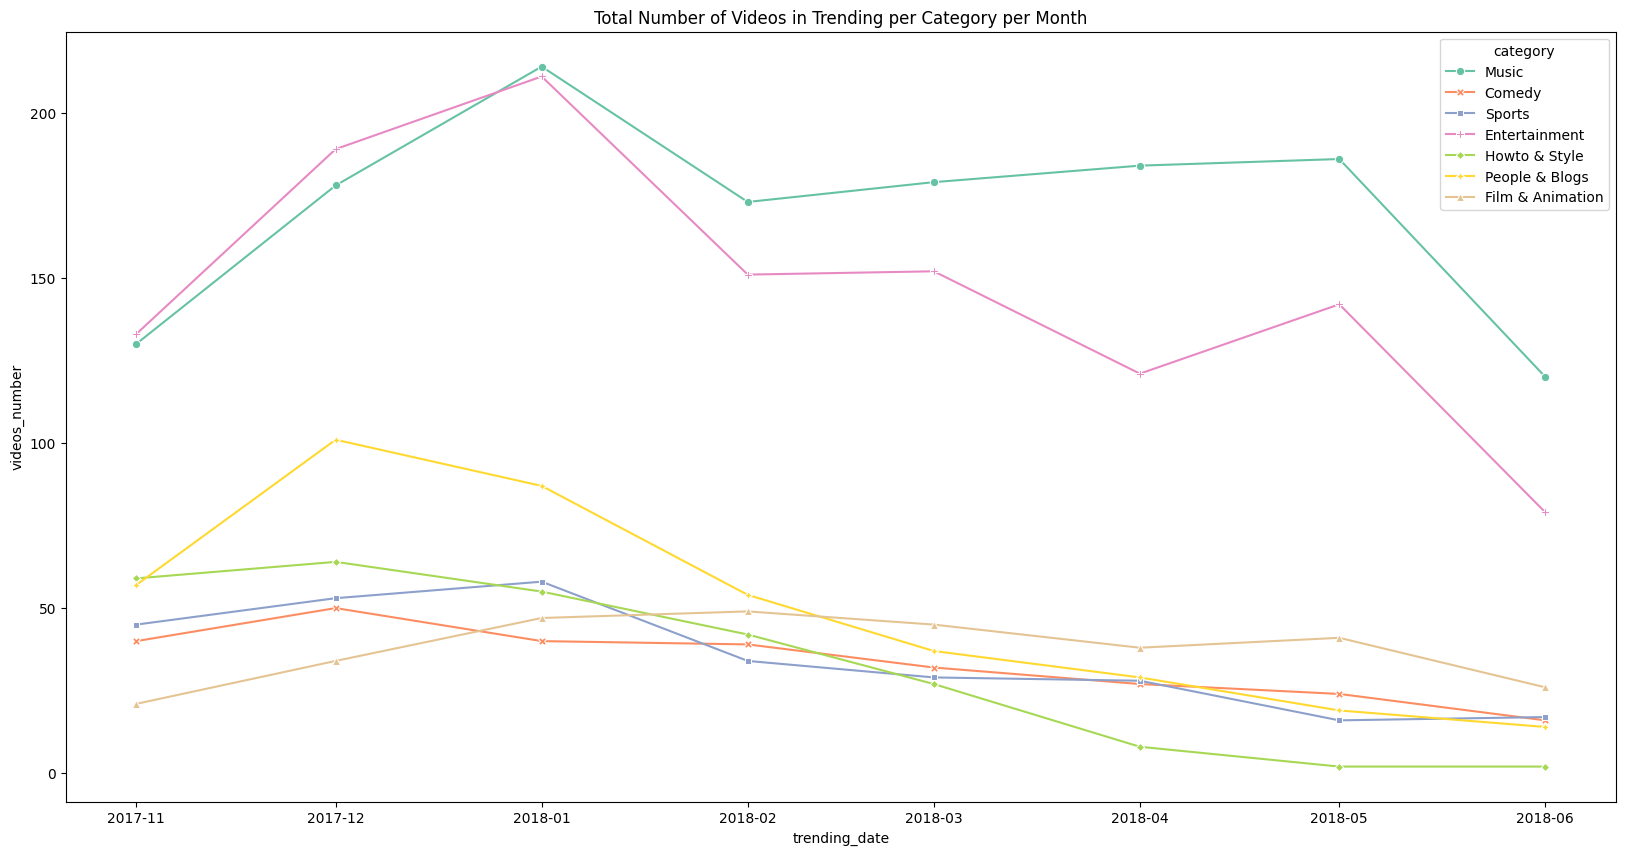

In [97]:
plotting_df = trending_monthly_stats.filter(pl.col("category").is_in(top_categories))

sns.lineplot(
    x=plotting_df["trending_date"],
    y=plotting_df["videos_number"],
    hue=plotting_df["category"],
    style=plotting_df["category"],
    markers=True,
    dashes=False,
    palette='Set2'
)

plt.title("Total Number of Videos in Trending per Category per Month")

From this plot we can see that Music has the largest share of Trending stating from 2018. This might indicate some strategic shift within YouTube to become the go-to platform for music videos. Entertainment seems to be on the gradual decline together with People & Blogs and Howto & Style categories.

#### Number of New Monthly Trending Videos per Category

The query is exactly the same, except now we need to provide as index_column the first the date when a video got into Trending.

Text(0.5, 1.0, ' Number of New Trending Videos per Category per Month')

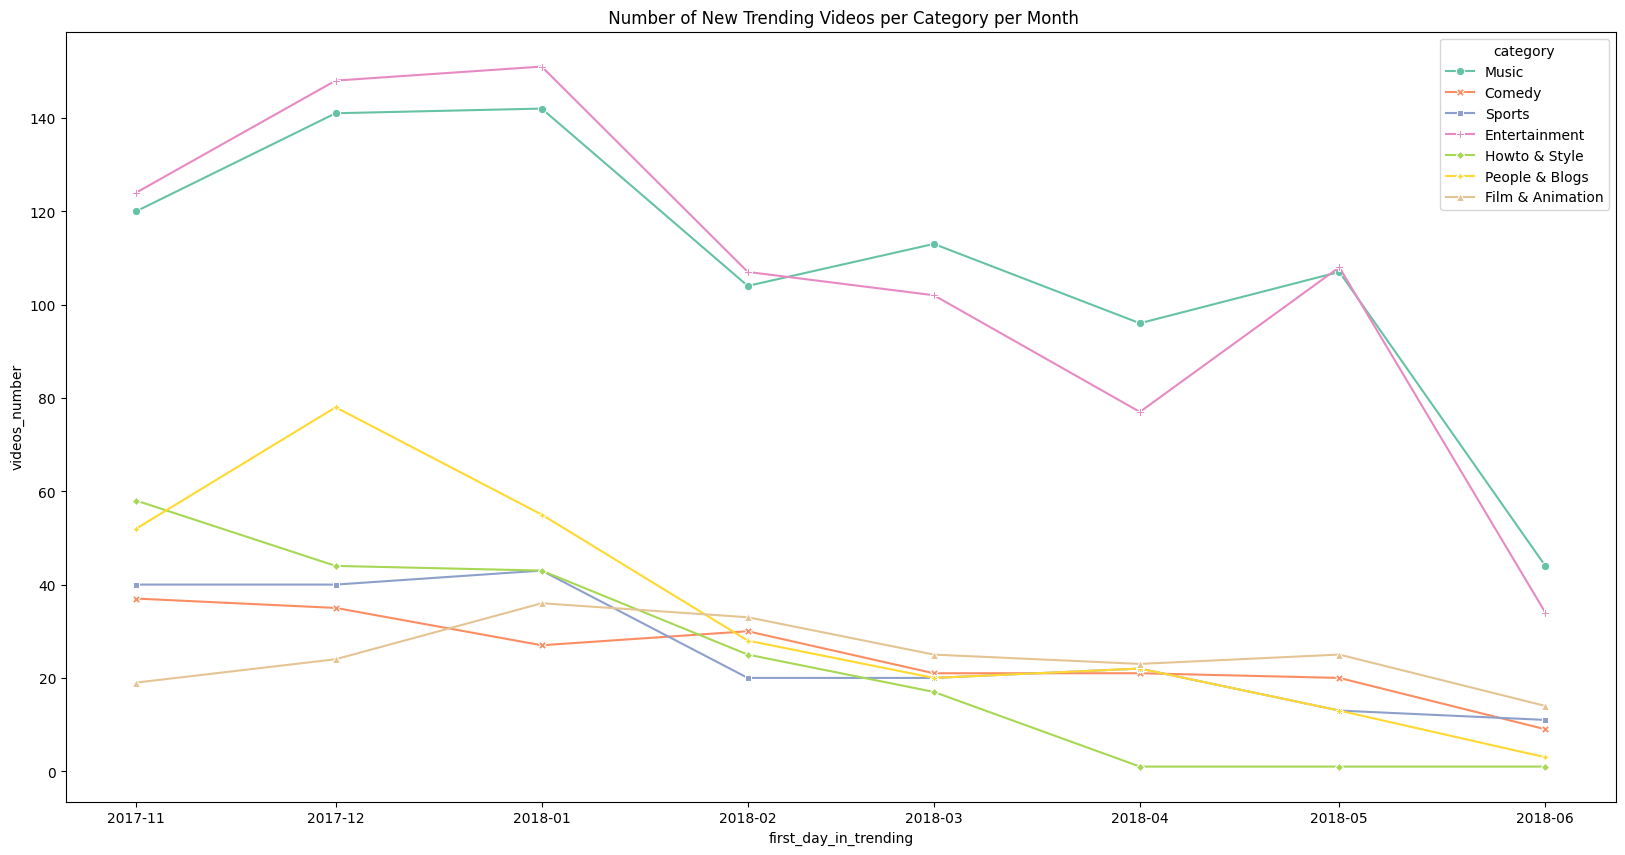

In [101]:
trending_monthly_stats_unique = (
    time_to_trending_df.sort("first_day_in_trending")
    .group_by_dynamic(
        index_column="first_day_in_trending",
        every="1mo",
        group_by="category",
        include_boundaries=True,
    )
    .agg(pl.col("video_id").n_unique().alias("videos_number"))
)

plotting_df = trending_monthly_stats_unique.filter(pl.col("category").is_in(top_categories))
sns.lineplot(
    x=plotting_df["first_day_in_trending"],
    y=plotting_df["videos_number"],
    hue=plotting_df["category"],
    style=plotting_df["category"],
    markers=True,
    dashes=False,
    palette='Set2'
)

plt.title(" Number of New Trending Videos per Category per Month")

Here we get an interesting insights – the number of new videos by Entertainment and Music is roughly equal throughout the time. Since Music videos stay in Trending much longer, they are overrepresented in the Trending counts, but when these videos are deduped this pattern disappears

#### Running Average of Views per Category

As the last step of this analysis, let’s compare two most popular categories (Music and Entertainment) according to their views over time. To perform this analysis, we’re going to use the 7 day running average statistic to visualise the trends. To calculate this rolling statistic Polars has a handy method called .groupby_rolling() . Before applying it though, let’s sum up all the views by category_id and trending_date and then sort the DataFrame accordingly. This format is required to correctly calculate the rolling statistics.

In [111]:
views_per_category_date = (
    df.group_by(["category", "trending_date"])
    .agg(pl.col("views").sum())
    .sort(["category", "trending_date"])
)

In [112]:
views_per_category_date.head()

category,trending_date,views
str,date,i64
"""Autos & Vehicles""",2017-11-14,2343797
"""Autos & Vehicles""",2017-11-15,2462434
"""Autos & Vehicles""",2017-11-16,951626
"""Autos & Vehicles""",2017-11-28,705169
"""Autos & Vehicles""",2017-11-29,1149806


Once the DataFrame is ready, we can use .groupby_rolling() method to create the rolling average statistic by specifying 1w in the period argument and creating an average expression in the .agg() method.

Text(0.5, 1.0, '7-day Views Average')

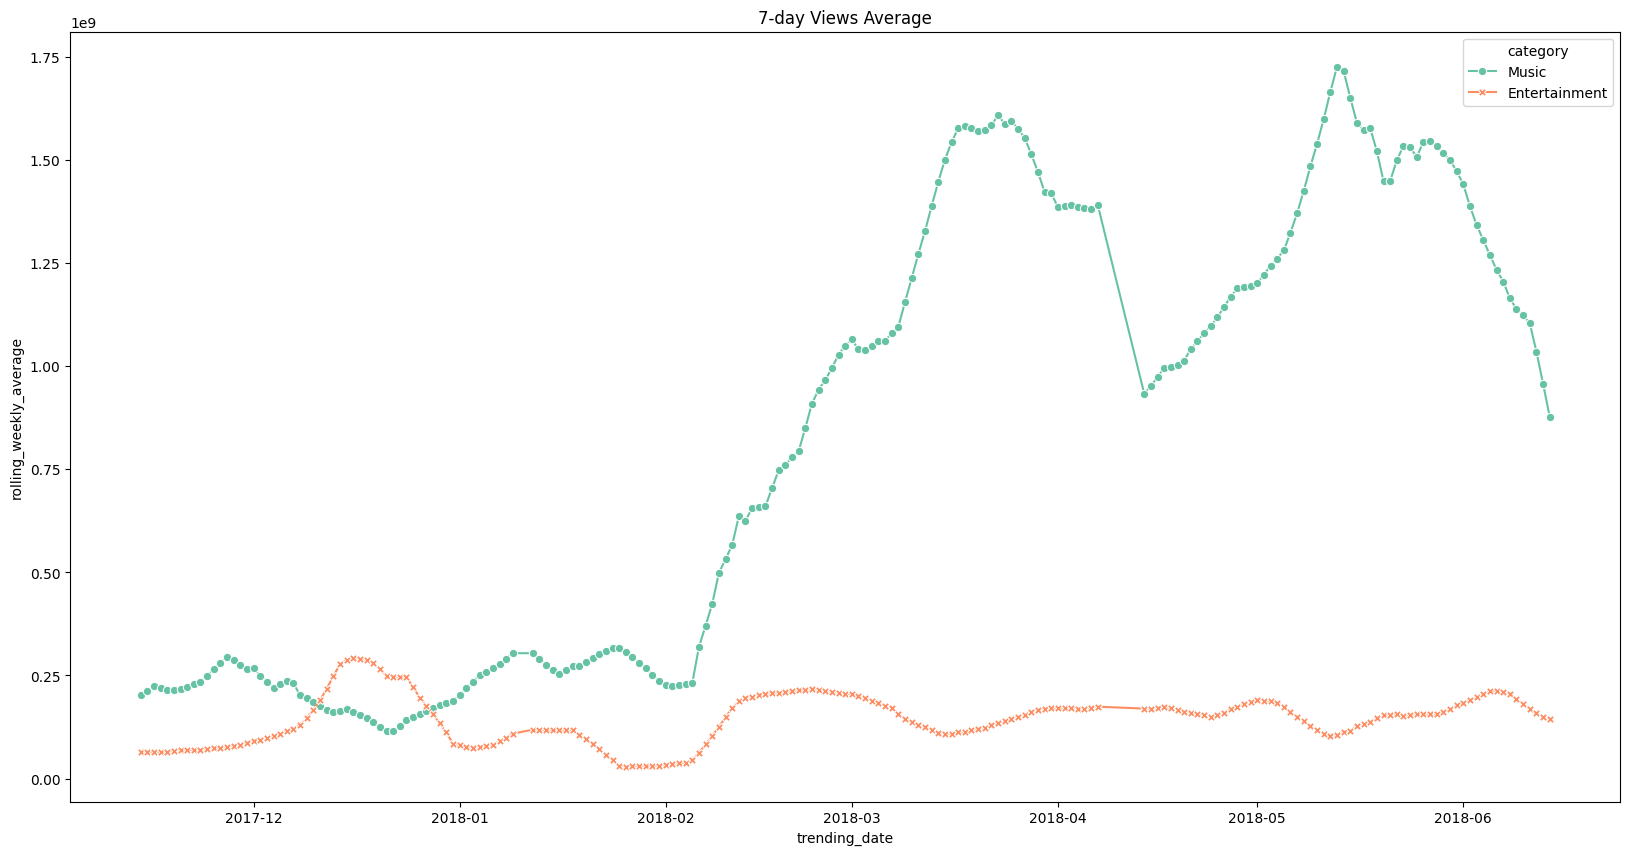

In [115]:
# Calculate rolling average
views_per_category_date_rolling = views_per_category_date.rolling(
    index_column="trending_date",  # Date column
    group_by="category",  # Grouping column
    period="1w"  # Rolling length
).agg(
    pl.col("views").mean().alias("rolling_weekly_average")
)

# Plotting
plotting_df = views_per_category_date_rolling.filter(pl.col("category").is_in(['Music', 'Entertainment']))
sns.lineplot(
    x=plotting_df["trending_date"],
    y=plotting_df["rolling_weekly_average"],
    hue=plotting_df["category"],
    style=plotting_df["category"],
    markers=True,
    dashes=False,
    palette='Set2'
)

plt.title("7-day Views Average")

According to the 7-day rolling average views, Music completely dominates the Trending tab and starting from February 2018 the gap between these two categories has increased massively.

### Thanks and Bye!